In [0]:
import tensorflow as tf 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data

In [3]:

mnist=input_data.read_data_sets("MNIST_Data/",one_hot=True)

Extracting MNIST_Data/train-images-idx3-ubyte.gz
Extracting MNIST_Data/train-labels-idx1-ubyte.gz
Extracting MNIST_Data/t10k-images-idx3-ubyte.gz
Extracting MNIST_Data/t10k-labels-idx1-ubyte.gz


In [0]:
batch_size=128
keep_prob= .5
image_size=28
num_labels=10
img_dim=784
disc_dim=256
noise_dim=200

In [0]:
tf.reset_default_graph() #run this cell every time you start training from new phase

In [0]:
def generator(features,reuse=False):

  with tf.variable_scope('Generator', reuse=tf.AUTO_REUSE):
    l1 = tf.nn.tanh(tf.layers.dense(features,units=6*6*128))
    l2= tf.reshape(l1,shape=[-1,6,6,128])
    l3= tf.layers.conv2d_transpose(l2,64,4,strides=2)
    l4= tf.layers.conv2d_transpose(l3, 1, 2, strides=2)

    predictions = tf.nn.sigmoid(l4)

  return predictions


def discriminator(features,reuse=False):

  with tf.variable_scope('Discriminator', reuse=tf.AUTO_REUSE):
    l1 = tf.nn.tanh(tf.layers.conv2d(features,64,5))
    l2 =tf.layers.average_pooling2d(l1, 2, 2)
    l3 = tf.nn.tanh(tf.layers.conv2d(l2,128,5))
    l4 = tf.layers.dropout(
           inputs=l3, rate=0.4)
    l5 = tf.layers.average_pooling2d(l4, 2, 2)
    l6 = tf.contrib.layers.flatten(l5)
    l7 = tf.nn.tanh(tf.layers.dense(l6,1024))

    
    logits=tf.layers.dense(l7,2)

  return logits

In [0]:
Z = tf.placeholder(tf.float32,shape=[None,noise_dim])
disc_inp=tf.placeholder(tf.float32,shape=[None,28,28,1])
disc_target = tf.placeholder(tf.int32, shape=[None])
gen_target = tf.placeholder(tf.int32, shape=[None])


In [0]:

prob=generator(Z)
logits=discriminator(disc_inp)
logit1=discriminator(prob,reuse=True)
disc_concat=tf.concat([logits,logit1],axis=0)
stacked_gan = discriminator(prob, reuse=True)



d_loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
    logits=disc_concat, labels=disc_target))
gen_loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
    logits=stacked_gan, labels=gen_target))
optim_gen=tf.train.AdamOptimizer(learning_rate=0.001)
optim_disc=tf.train.AdamOptimizer(learning_rate=0.001)


gen_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='Generator')
disc_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='Discriminator')

training_disc=optim_disc.minimize(d_loss,var_list=disc_vars)
training_gen=optim_gen.minimize(gen_loss,var_list=gen_vars)


In [0]:
init = tf.global_variables_initializer()


Step 1: Generator Loss: 0.742145, Discriminator Loss: 0.674770


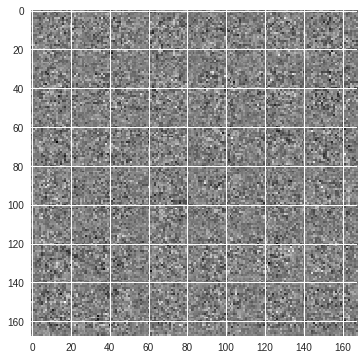

Step 1000: Generator Loss: 4.212021, Discriminator Loss: 0.183519


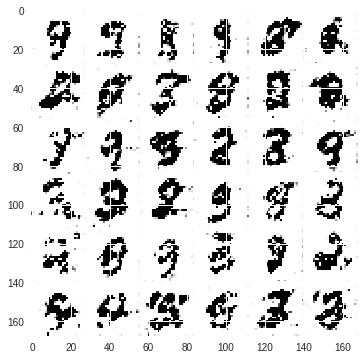

Step 2000: Generator Loss: 6.497142, Discriminator Loss: 0.066335


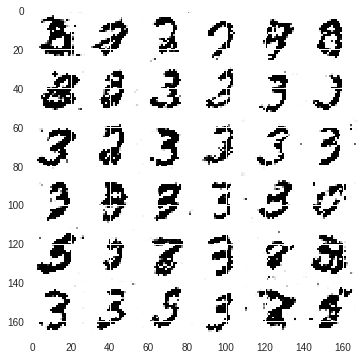

Step 3000: Generator Loss: 4.528119, Discriminator Loss: 0.034539


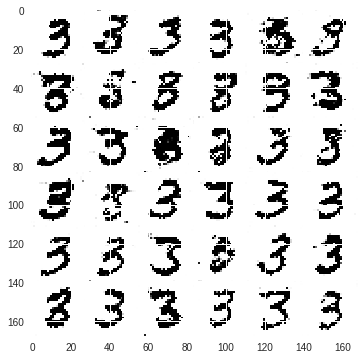

Step 4000: Generator Loss: 4.740214, Discriminator Loss: 0.072843


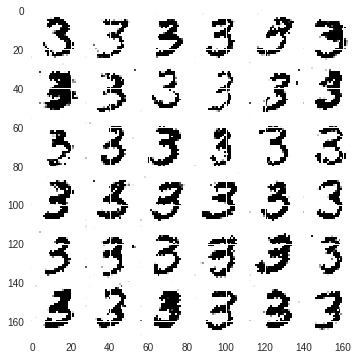

Step 5000: Generator Loss: 4.977212, Discriminator Loss: 0.058374


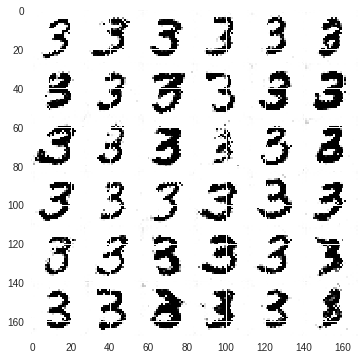

Step 6000: Generator Loss: 5.981272, Discriminator Loss: 0.037866


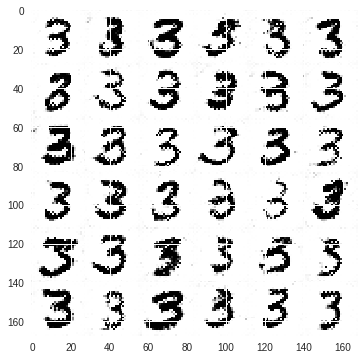

Step 7000: Generator Loss: 4.556592, Discriminator Loss: 0.042380


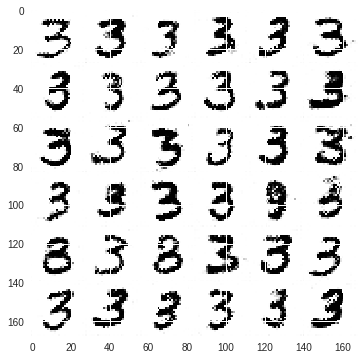

Step 8000: Generator Loss: 6.193813, Discriminator Loss: 0.044985


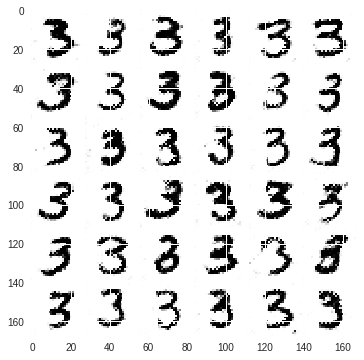

Step 9000: Generator Loss: 4.546385, Discriminator Loss: 0.082461


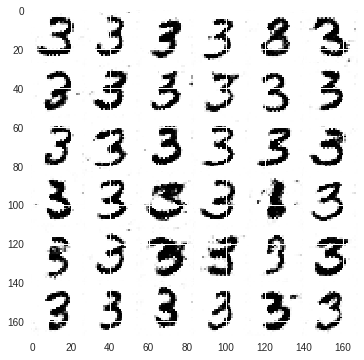

Step 10000: Generator Loss: 5.542541, Discriminator Loss: 0.053479


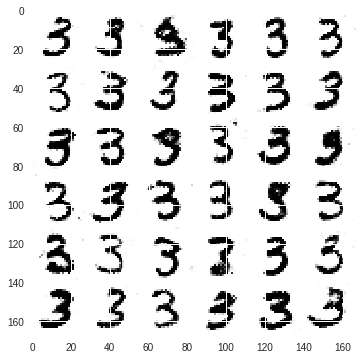

Step 11000: Generator Loss: 5.867202, Discriminator Loss: 0.070903


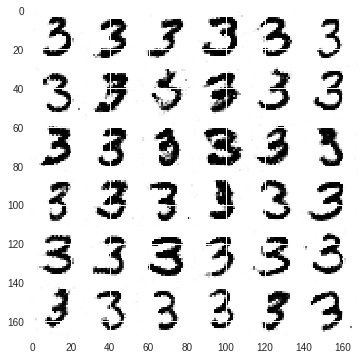

Step 12000: Generator Loss: 5.596570, Discriminator Loss: 0.109236


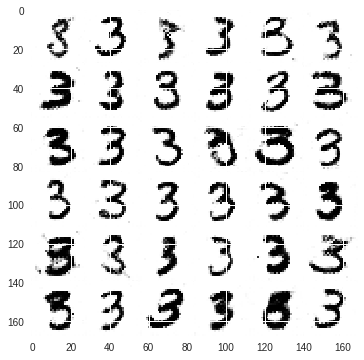

Step 13000: Generator Loss: 5.573261, Discriminator Loss: 0.026148


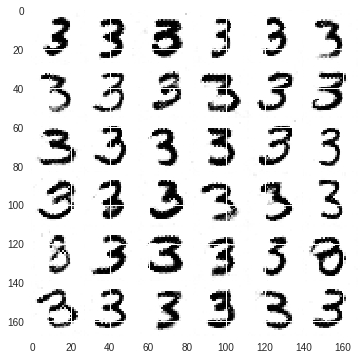

Step 14000: Generator Loss: 6.458166, Discriminator Loss: 0.033976


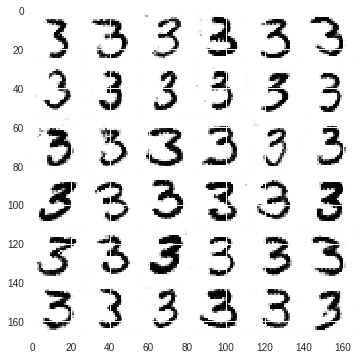

Step 15000: Generator Loss: 7.381598, Discriminator Loss: 0.062410


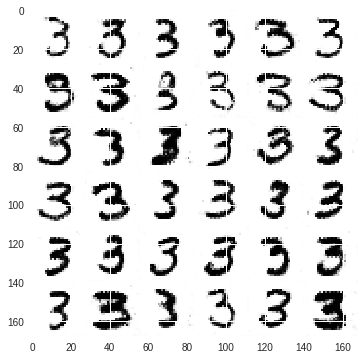

Step 16000: Generator Loss: 7.159798, Discriminator Loss: 0.031107


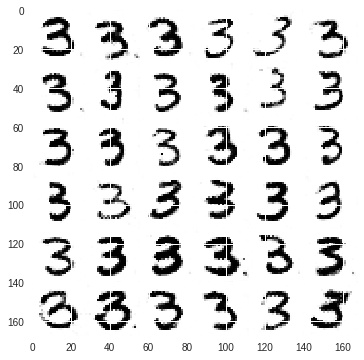

Step 17000: Generator Loss: 8.409281, Discriminator Loss: 0.022563


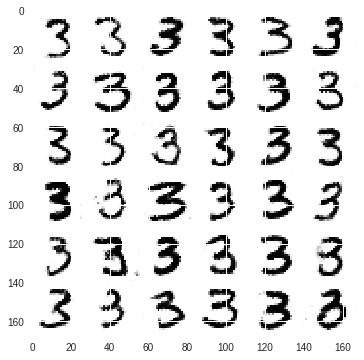

Step 18000: Generator Loss: 7.964113, Discriminator Loss: 0.016031


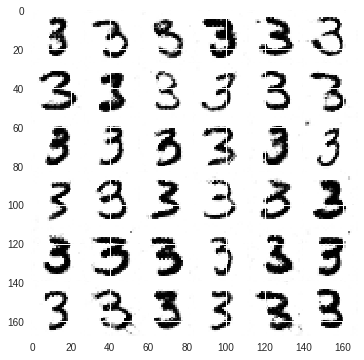

Step 19000: Generator Loss: 7.472833, Discriminator Loss: 0.036318


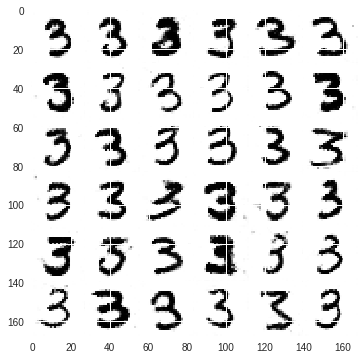

Step 20000: Generator Loss: 12.103462, Discriminator Loss: 0.069369


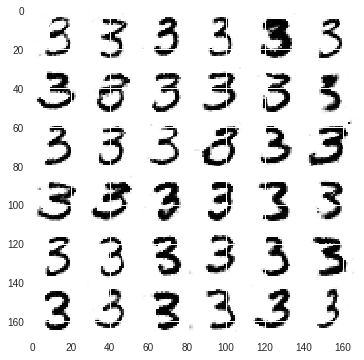

Finished!


In [10]:
with tf.Session() as sess:

    sess.run(init)

    for step in range(1, 20000+1):
        batch_x, _ = mnist.train.next_batch(batch_size)
        batch_x=batch_x.reshape(-1,28,28,1)

        noise_temp = np.random.uniform(-1., 1., size=[batch_size,noise_dim])
        batch_disc_y = np.concatenate(
            [np.ones([batch_size]), np.zeros([batch_size])], axis=0)
        batch_gen_y = np.ones([batch_size])

        feed_dict = {disc_inp: batch_x, Z: noise_temp,disc_target: batch_disc_y, gen_target: batch_gen_y}
        _,_, gl, dl = sess.run([training_gen,training_disc, gen_loss, d_loss],
                            feed_dict=feed_dict)
        if step % 1000 == 0 or step == 1:
            print('Step %i: Generator Loss: %f, Discriminator Loss: %f' % (step, gl, dl))
            n = 6
            canvas = np.empty((28 * n, 28 * n))
            
            for i in range(n):
              z = np.random.uniform(-1., 1., size=[n,noise_dim])
              g = sess.run(prob, feed_dict={Z: z})
              g = -1 * (g - 1)
              for j in range(n):
                canvas[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = g[j].reshape([28, 28])

            plt.figure(figsize=(n, n))
            plt.imshow(canvas, origin="upper", cmap="gray")
            plt.show()


    
    print("Finished!")
